<a href="https://colab.research.google.com/github/jobellet/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex/blob/main/Preprocess_vlPFC_spikes_and_eye_signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# This notebook reproduce the preprocessing steps used to align the spike times and eye signal to the time of stimulus onset
---
For the notebook to download the data from the Figshare repository prior to acceptance of the manuscript you need to insert the private link token mentioned in the "Code availability" section of the manuscript.
---

In [ ]:
private_link = input('Enter the private link token:')

# Import repository and download data

In [2]:
files_to_download = ['continuous_signals_spikes_and_events.zip','myweights']
import os
import sys
import shutil
IN_COLAB = False
IN_KAGGLE = False
try:
    if 'google.colab' in str(get_ipython()):
        IN_COLAB = True
except NameError:
    pass
if not IN_COLAB:
    if os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Localhost') == 'Interactive':
        IN_KAGGLE = True



if IN_COLAB:
    path_to_repo = '/content/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex'
elif IN_KAGGLE:
    path_to_repo = '/kaggle/working/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex'
else:
    path_to_repo = 'Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex/'
# Only clone if not already present
if not os.path.exists(path_to_repo):
    os.system("git clone https://github.com/jobellet/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex.git " + path_to_repo)
sys.path.append(path_to_repo)


from utils.extract_and_download_data import download_files, unzip

# Load the file-code mapping

download_files(path_to_repo, files_to_download, private_link=private_link)
zip_path =  os.path.join('downloads', 'continuous_signals_spikes_and_events.zip')
unzip(zip_path,'raw_data')

Successfully downloaded downloads/continuous_signals_spikes_and_events.zip.
Successfully downloaded downloads/myweights.


### Align Spikes, Eye Traces, and Pupil Data to Stimulus Onset Times  
*(0 → 200 ms relative to stimulus onse)*

This script loops through each recording-day `.mat` file and generates three aligned outputs per day:

1. **Neural spike counts** — `YYYYMMDD_stim_aligned_count.npy`  
   *shape (nTrials × 96 channels × 20 bins, 10 ms/bin; 0–200 ms)*  
2. **Calibrated eye-position traces** — `YYYYMMDD_eye_pos.npy`  
   *shape (nTrials × 400 samples × 2 axes, 0.2 s at 2 kHz; 0–200 ms)*  
3. **Baseline-corrected pupil traces** — `YYYYMMDD_pupil_aligned.npy`  
   *shape (nTrials × 400 samples, 0.2 s at 2 kHz; 0–200 ms)*  

#### Processing Pipeline

| Stage | Details |
|-------|---------|
| **Input discovery** | Scans the working directory for files matching `20*.mat`; skips any that already have all three output `.npy` files. |
| **Data loading** | Reads spike times, eye traces (`eye_pos_x`, `eye_pos_y`), pupil size (`eye_pupil`), and stimulus onsets (`stimTime`). |
| **Stimulus-time correction** | Shifts each onset **½ video frame earlier** (−8.33 ms at 60 Hz) to compensate for photodiode delay, then converts to sample indices (30 kHz). |
| **Eye-position alignment** | Extracts a **200 ms window (0 → +200 ms)** @ 2 kHz, subtracts the median of the neighbouring 15 trials to compensate the slow measurement drift, and maps raw voltages to ° of visual angle via a fixed 2 × 3 affine transform. |
| **Spike binning** | Counts spikes in 10 ms bins (**20 bins spanning 0 → +200 ms**) for each of 96 channels using Numba-accelerated search-sorted binning. |
| **Pupil alignment** | Extracts the same 200 ms window from `eye_pupil` and subtract the median of the neighbouring 15 trials to compensate the slow measurement drift |
| **Saving** | Writes the three outputs with date-encoded filenames so downstream scripts can locate them easily. |
| **Parallel execution** | Uses `multiprocessing.Pool` to process multiple recording days in parallel. |


In [3]:
import os
import re
import zipfile
from glob import glob
import numpy as np
import numba
import multiprocessing
from tqdm import tqdm
from scipy.io import loadmat
from scipy.signal import medfilt as movmedian   # simple 1-D median filter
import pandas as pd

# ---------- geometry helper --------------------------------------------------
def transform_points(points):
    """Affine transform from voltage space to visual-angle space (hard-coded)."""
    T_hard_coded = np.array([[ 6.86341798e-03,  3.92195313e-04, -2.22044166e-16],
                             [-1.16678106e-03,  5.64761251e-03, -4.03638942e-16]])
    points_h = np.hstack([points, np.ones((points.shape[0], 1))])  # hom. coords
    return (points_h @ T_hard_coded.T)[:, :2]

# ---------- eye-trace alignment ----------------------------------------------
def calibrate_and_align_eye_pos(eye_pos_x, eye_pos_y, stimulus_times):
    """
    Aligns eye position traces in the window 0–300 ms relative to stimulus onset.
    We take more samples to find end points of microsaccade starting just before the next image onset
    We will crop to 200 ms post stimulus onset after
    Returns: eye_pos (nTrials × 400 × 2), in_fix mask (nTrials × 400).
    """
    rate = 2000          # Hz
    post = int(0.3 * rate)   # 600 samples, 300 ms
    baseline_len = 40     # first 20 ms for baseline subtraction

    stim_idx = (stimulus_times * rate).astype(np.int32)[:, None]
    indices  = stim_idx + np.arange(0, post)             # 0 → +299 ms

    X = eye_pos_x[0, indices]
    Y = eye_pos_y[0, indices]

    # median baseline (20 ms) per trial
    X_med = movmedian(np.mean(X[:, :baseline_len], axis=1), 151).reshape(-1, 1)
    Y_med = movmedian(np.mean(Y[:, :baseline_len], axis=1), 151).reshape(-1, 1)

    X_adj = X - X_med
    Y_adj = Y - Y_med

    pts   = np.column_stack((X_adj.ravel(), Y_adj.ravel()))
    out   = transform_points(pts).reshape(X_adj.shape[0], post, 2)

    in_fix = (np.linalg.norm(out, axis=2) < 2)  # 2° radius fixation window
    return out, in_fix

# ---------- pupil alignment ---------------------------------------------------
def align_pupil_data(eye_pupil, stimulus_times):
    """
    Aligns pupil traces to stimulus onset, keeping only 0–200 ms.
    Returns: pupil_aligned (nTrials × 400).
    """
    rate = 2000
    post = int(0.2 * rate)   # 400 samples
    stim_onset_sample_rate = 30000 # Hz, sample rate of stimulus time stamps

    # Replace NaN values with nanmedian of the whole signal
    pupil_data = eye_pupil[0].copy() # Create a copy to avoid modifying original data
    pupil_nanmedian = np.nanmedian(pupil_data)
    pupil_data[np.isnan(pupil_data)] = pupil_nanmedian

    # Get pupil value at stimulus onset (convert stimulus time to pupil samples)
    stim_onset_pupil_samples = (stimulus_times * rate).astype(int)

    # Apply median filter across trials using pupil at stimulus onset
    pupil_at_onset = pupil_data[stim_onset_pupil_samples]
    pupil_trend = movmedian(pupil_at_onset, 151) # Window of 151 trials

    # Align pupil traces
    stim_idx = (stimulus_times * rate).astype(np.int32)[:, None]
    indices  = stim_idx + np.arange(0, post)

    pupil_aligned = pupil_data[indices]

    # Subtract the trial-wise trend from the aligned pupil data
    pupil_detrended = pupil_aligned - pupil_trend[:, None]

    return pupil_detrended

# ---------- spike-count binning ----------------------------------------------
TIME_WINDOW = 10 * 30        # 300 samples = 10 ms @ 30 kHz
NUM_BINS    = 20             # 0–200 ms
@numba.njit
def compute_channel_counts(spike_times, edges):
    return np.diff(np.searchsorted(spike_times, edges)).astype(np.int32)

def get_spike_count(spike, t):
    """
    Compute 10 ms spike counts from 0–200 ms after stimulus onset.
    Returns: (96 × 20) int32 array.
    """
    edges = np.arange(t, t + (NUM_BINS + 1) * TIME_WINDOW, TIME_WINDOW)
    counts = np.zeros((96, NUM_BINS), dtype=np.int32)
    for ch in range(96):
        st = spike[0][ch][0, :]   # 1-D sorted spike times (samples)
        counts[ch, :] = compute_channel_counts(st, edges)
    return counts

# ---------- per-file processing ----------------------------------------------
def process_file(mat_file):
    print(f"Processing {mat_file}")
    base = os.path.splitext(os.path.basename(mat_file))[0]
    f_spk, f_eye, f_pup = [f"aligned_data/{base}_{suffix}.npy" for suffix in
                           ("stim_aligned_count", "eye_pos", "pupil_aligned")]
    if all(os.path.exists(f) for f in (f_spk, f_eye, f_pup)):
        print("  → outputs already exist, skipping.")
        return

    try:
        m = loadmat(mat_file)
        stimTime = m["stimTime"][0]       # seconds
        spike    = m["spike"]
        eye_x    = m["eye_pos_x"]
        eye_y    = m["eye_pos_y"]
        eye_pup  = m["eye_pupil"]

        # Constant photodiode correction (–8.33 ms) to prevent underestimating response delay in vlPFC due screen rolling shutter effect
        stim_corr = stimTime - (1 / 60) / 2

        eye_pos, _ = calibrate_and_align_eye_pos(eye_x, eye_y, stim_corr)
        pupil      = align_pupil_data(eye_pup, stim_corr)

        stim_counts = np.zeros((len(stim_corr), 96, NUM_BINS), dtype=np.int32)
        stim_corr_samples = (stim_corr * 30000).astype(np.int32)

        for s, t in tqdm(enumerate(stim_corr_samples),
                         total=len(stim_corr_samples),
                         desc=f"Spikes {base}"):
            stim_counts[s] = get_spike_count(spike, t)

        np.save(f_spk, stim_counts)
        np.save(f_eye, eye_pos)
        np.save(f_pup, pupil)

    except Exception as e:
        print(f"Error processing {mat_file}: {e}")

# ---------- main entry-point --------------------------------------------------
if __name__ == "__main__":
    os.makedirs('aligned_data/', exist_ok=True)
    with multiprocessing.Pool() as pool:
        pool.map(process_file, glob(os.path.join('raw_data',"20*.mat")))

Processing raw_data/20201023.mat
Processing raw_data/20201030.mat


Spikes 20201030:  64%|██████▎   | 3906/6136 [00:08<00:01, 1280.35it/s]

Processing raw_data/20201021.mat


Spikes 20201030: 100%|██████████| 6136/6136 [00:09<00:00, 637.32it/s] 


Processing raw_data/20201112.mat


Spikes 20201021: 100%|██████████| 2365/2365 [00:02<00:00, 862.08it/s] 


Processing raw_data/20201110.mat


Spikes 20201110:  47%|████▋     | 3960/8457 [00:03<00:04, 1117.40it/s]

Processing raw_data/20201020.mat


Spikes 20201110:  97%|█████████▋| 8241/8457 [00:06<00:00, 1136.65it/s]

Processing raw_data/20201026.mat


Spikes 20201110: 100%|██████████| 8457/8457 [00:06<00:00, 1222.31it/s]


Processing raw_data/20201028.mat


Spikes 20201026:  83%|████████▎ | 5572/6718 [00:04<00:00, 1302.20it/s]

Processing raw_data/20201109.mat


Spikes 20201026: 100%|██████████| 6718/6718 [00:05<00:00, 1269.83it/s]


Processing raw_data/20201106.mat


Spikes 20201106:  90%|█████████ | 5164/5731 [00:05<00:00, 881.25it/s]

Processing raw_data/20201102.mat


Spikes 20201106: 100%|██████████| 5731/5731 [00:06<00:00, 948.44it/s]


Processing raw_data/20201027.mat


Spikes 20201027:  82%|████████▏ | 5085/6213 [00:03<00:00, 1289.84it/s]

Processing raw_data/20201103.mat


Spikes 20201027: 100%|██████████| 6213/6213 [00:04<00:00, 1297.59it/s]


Processing raw_data/20201029.mat


Spikes 20201103:  87%|████████▋ | 7213/8282 [00:08<00:00, 1231.52it/s]

Processing raw_data/20201104.mat


Spikes 20201103: 100%|██████████| 8282/8282 [00:09<00:00, 897.16it/s] 


Processing raw_data/20201022.mat


Spikes 20201104: 100%|██████████| 9530/9530 [00:05<00:00, 1833.92it/s]


### Aggregate Daily Outputs & Down-sample Eye/Pupil Signals to match spike count 10 ms binning

This script collates the per-day `.npy` files created above into single, experiment-wide arrays and a tidy metadata table:

1. **Spike counts** → `aggregated_spike_counts.npy`  
   *shape (nTotalTrials × 96 × 20)*  
2. **Eye position** (down-sampled to 100 Hz) → `aggregated_eye_pos.npy`  
   *shape (nTotalTrials × 20 × 2)*  
3. **Pupil traces** (down-sampled to 100 Hz) → `aggregated_pupil.npy`  
   *shape (nTotalTrials × 20)*  
4. **Trial-wise metadata CSV** → `metadata.csv`  
   Columns: global trial index, recording date, `stimId`, original `stimTime`.

#### Key Steps

1. **File matching** – Identifies every `.mat` file beginning with `20`. For each, it expects the three aligned outputs generated by Script 1; files lacking them are skipped with a warning.  
2. **Down-sampling** – Eye and pupil traces (2 kHz) are reduced to 100 Hz (20×) using `downsample_array`, preserving the **0 → 200 ms** window as **20 samples**.  
3. **Data stacking** – Trial-level arrays are appended to running lists; after all days are processed, `np.concatenate` merges them along the trial axis.  
4. **Metadata assembly** – A `pandas` DataFrame stores per-trial identifiers and is written to CSV


In [4]:
def downsample_array(array, factor, axis):
    """
    Downsample a NumPy array along a specified axis by a given factor.

    Parameters:
    - array: np.ndarray, input data of any shape.
    - factor: int, downsampling factor (keep every `factor`-th element). For instance factor = 2 halfs the sampling rate.
    - axis: int, axis along which to downsample.

    Returns:
    - downsampled_array: np.ndarray, array downsampled along the specified axis.
    """
    # Build a slicing object: slice(None) for all axes, except step-slice on the target axis
    slicer = [slice(None)] * array.ndim
    slicer[axis] = slice(None, None, factor)
    return array[tuple(slicer)]


# List all .mat files starting with "20" in the current directory
mat_files = glob(os.path.join('raw_data','20*.mat'))

# Prepare lists to accumulate data from all files
all_metadata = []
all_spike_counts = []
all_eye_pos = []
all_pupil = []
all_eye_pos_250 = [] # New list for 250 Hz eye position

# Running counter for total trials
total_trials = 0

for mat_file in mat_files:
    base = os.path.splitext(os.path.basename(mat_file))[0]
    print(f"Processing file: {base}")

    spike_file = f"aligned_data/{base}_stim_aligned_count.npy"
    eye_file   = f"aligned_data/{base}_eye_pos.npy"
    pupil_file = f"aligned_data/{base}_pupil_aligned.npy"

    if not (os.path.exists(mat_file) and os.path.exists(spike_file)
            and os.path.exists(eye_file) and os.path.exists(pupil_file)):
        print(f"Skipping file {base}: required files not found.")
        continue

    mat_data = loadmat(mat_file)
    stimId   = mat_data['stimId'][0] if 'stimId' in mat_data else None
    stimTime = mat_data['stimTime'][0] if 'stimTime' in mat_data else None

    recording_date = base

    stim_aligned_count = np.load(spike_file)  # shape: (nTrials, 96, 20)
    eye_pos            = np.load(eye_file)    # shape: (nTrials, 400, 2)
    pupil_aligned      = np.load(pupil_file)  # shape: (nTrials, 400)

    nTrials = stim_aligned_count.shape[0]

    # Downsample from 2 kHz → 100 Hz (factor 20): 400 → 20 samples
    eye_pos_downsampled   = downsample_array(eye_pos, factor=20, axis=1)[:,:20]    # (nTrials, 20, 2)
    pupil_downsampled     = downsample_array(pupil_aligned, factor=20, axis=1)  # (nTrials, 20)

    # Downsample from 2 kHz → 250 Hz (factor 8): 600 → 75 samples
    eye_pos_downsampled_250 = downsample_array(eye_pos, factor=8, axis=1) # (nTrials, 50, 2)

    for i in range(nTrials):
        all_metadata.append({
            'trial_index_global': total_trials + i,
            'recording_date': recording_date,
            'stimId': stimId[i] if stimId is not None else None,
            'time_of_stimulus': stimTime[i] if stimTime is not None else None
        })

    all_spike_counts.append(stim_aligned_count.astype(np.int8))
    all_eye_pos.append(eye_pos_downsampled.astype(np.float32))
    all_pupil.append(pupil_downsampled.astype(np.float32))
    all_eye_pos_250.append(eye_pos_downsampled_250.astype(np.float32)) # Append 250 Hz data

    total_trials += nTrials

# Final concatenation
all_spike_counts = np.concatenate(all_spike_counts, axis=0)  # (nTotalTrials, 96, 20)
all_eye_pos      = np.concatenate(all_eye_pos, axis=0)       # (nTotalTrials, 20, 2)
all_pupil        = np.concatenate(all_pupil, axis=0)         # (nTotalTrials, 20)
all_eye_pos_250  = np.concatenate(all_eye_pos_250, axis=0)   # (nTotalTrials, 50, 2) # Concatenate 250 Hz data

metadata_df = pd.DataFrame(all_metadata)

# Save outputs
metadata_df.to_csv("recording_metadata.csv", index=False)
np.save("aggregated_spike_counts.npy", all_spike_counts)
np.save("aggregated_eye_pos.npy", all_eye_pos)
np.save("aggregated_pupil.npy", all_pupil)
np.save("aggregated_eye_pos_250.npy", all_eye_pos_250) # Save 250 Hz data

# Sanity print
print("Data aggregation complete!")
print(f"Total trials aggregated: {total_trials}")
print(f"Metadata shape: {metadata_df.shape}")
print(f"Spike count array shape: {all_spike_counts.shape}")
print(f"Eye position array shape (100 Hz): {all_eye_pos.shape}")
print(f"Eye position array shape (250 Hz): {all_eye_pos_250.shape}") # Print shape of 250 Hz data
print(f"Pupil array shape: {all_pupil.shape}")

Processing file: 20201023
Processing file: 20201021
Processing file: 20201030
Processing file: 20201112
Processing file: 20201110
Processing file: 20201028
Processing file: 20201020
Processing file: 20201026
Processing file: 20201109
Processing file: 20201102
Processing file: 20201106
Processing file: 20201027
Processing file: 20201103
Processing file: 20201022
Processing file: 20201029
Processing file: 20201104
Data aggregation complete!
Total trials aggregated: 97806
Metadata shape: (97806, 4)
Spike count array shape: (97806, 96, 20)
Eye position array shape (100 Hz): (97806, 20, 2)
Eye position array shape (250 Hz): (97806, 75, 2)
Pupil array shape: (97806, 20)


## Detect microsaccades in the 250 Hz eye signal and save a microsaccade metadata

In [12]:
aggregated_eye_pos250 = np.load("aggregated_eye_pos_250.npy")
X = aggregated_eye_pos250[:,:,0].clip(-10,10)
Y = aggregated_eye_pos250[:,:,1].clip(-10,10)

# download U'n'Eye
!git clone https://github.com/berenslab/uneye.git

Path_to_UnEye_folder = '/content/uneye/'
# go to the uneye folder
import os
os.chdir(Path_to_UnEye_folder)
from os.path import exists
import uneye
# move the file myweights to /uneye/training
shutil.move('/content/downloads/myweights', '/content/uneye/training')
def calculate_velocity(X, Y, dt=1):
    """ Calculate velocity from position data """
    Vx = np.diff(X, axis=1, append=X[:, -1:]) / dt
    Vy = np.diff(Y, axis=1, append=Y[:, -1:]) / dt
    return np.sqrt(Vx**2 + Vy**2)


def find_saccades(L):
    """Find start and end indices of saccades in a faster, more vectorized way.

    Each saccade is represented by a tuple:
      (trial, start_time, end_time)
    If a saccade has not ended, its end is set to n_time - 1.
    """
    n_trials, n_time = L.shape
    # Compute the difference along time axis after converting to int8.
    diffL = np.diff(L.astype(np.int8), axis=1, prepend=0)

    # Identify start and end events.
    start_rows, start_cols = np.where(diffL == 1)
    end_rows, end_cols = np.where(diffL == -1)

    saccades = []

    # Process each trial separately.
    for trial in range(n_trials):
        # Extract start and end times for the current trial.
        trial_starts = start_cols[start_rows == trial]
        trial_ends = end_cols[end_rows == trial]

        # If no start events, skip the trial.
        if trial_starts.size == 0:
            continue

        # For each start, find the insertion point in the sorted trial_ends array.
        indices = np.searchsorted(trial_ends, trial_starts, side='right')

        # Prepare an array to hold the end times.
        ends_for_trial = np.empty(trial_starts.shape, dtype=int)
        valid = indices < trial_ends.size

        # For valid indices, set the corresponding trial_ends.
        ends_for_trial[valid] = trial_ends[indices[valid]]
        # For indices out of bounds, assign n_time - 1.
        ends_for_trial[~valid] = n_time - 1

        # Append the results as tuples.
        saccades.extend(zip(np.full(trial_starts.shape, trial), trial_starts, ends_for_trial))

    return np.array(saccades, dtype='object')

def median_position(X, Y, trials,times, offset):
    """ Compute median position around given indices with an offset """
    positions = []

    for i, t in zip(trials, times):
        t_start, t_end = max(t + offset[0], 0), min(t + offset[1], X.shape[1])
        median_x = np.median(X[i, t_start:t_end])
        median_y = np.median(Y[i, t_start:t_end])
        positions.append((median_x, median_y))
    return positions

def save_data(df, output_folder, filename):
    """ Saves the DataFrame in CSV and MATLAB .mat formats. """
    # Ensure output directory exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    pkl_path = os.path.join(output_folder, f"{filename}.pkl")
    df.to_pickle(pkl_path)
min_sacc_dur = 10 #minimum saccade duration in ms
min_sacc_dist = 10 #minimum saccade distance in ms
sampfreq = 250 #Hz

weights_name = 'myweights'

# create model
model = uneye.DNN(weights_name=weights_name,
                 sampfreq=sampfreq,
                 min_sacc_dur=min_sacc_dur,
                 min_sacc_dist=min_sacc_dist,)

# Label data
L,P = model.predict(X,Y)

velocity = calculate_velocity(X, Y)

saccades_bounds = find_saccades(L)
trials,saccade_starts, saccade_ends = saccades_bounds[:,0],saccades_bounds[:,1],saccades_bounds[:,2]
start_positions = median_position(X, Y, trials,saccade_starts, offset=(-10, 0))
end_positions = median_position(X, Y, trials,saccade_ends, offset=(0, 10))

saccades = []
for i,t_start, t_end, start_pos, end_pos in zip(trials,saccade_starts, saccade_ends, start_positions, end_positions):

    duration = t_end - t_start
    amplitude = np.sqrt(np.sum((np.array(end_pos)-np.array(start_pos))**2))
    peak_velocity_time = np.argmax(velocity[i, t_start:t_end]) + t_start
    peak_velocity = velocity[i, peak_velocity_time]
    delta_x = end_pos[0] - start_pos[0]
    delta_y = end_pos[1] - start_pos[1]
    polar_angle = np.arctan2(delta_y, delta_x) # Calculate polar angle in radians

    saccades.append({
        "Trial": i,
        "Start_Time": t_start/250,
        "Stop_Time": t_end/250,
        "Duration": duration/250,
        "Start_X": start_pos[0],
        "Start_Y": start_pos[1],
        "Stop_X": end_pos[0],
        "Stop_Y": end_pos[1],
        "Amplitude": amplitude,
        "Peak_Velocity": peak_velocity/250,
        "Time_of_Peak_Velocity": (peak_velocity_time - t_start)/250,
        "polar_angle": polar_angle # Add polar angle to the dictionary
    })

df_saccades = pd.DataFrame(saccades)
df_saccades = df_saccades[df_saccades.Start_Time<=.2] # remove saccades starting after next stimulus onset
save_data(df_saccades, '/content', 'saccade_data')
os.chdir('/content')

Cloning into 'uneye'...
remote: Enumerating objects: 990, done.
remote: Total 990 (delta 0), reused 0 (delta 0), pack-reused 990 (from 1)
Receiving objects: 100% (990/990), 169.38 MiB | 23.06 MiB/s, done.
Resolving deltas: 100% (211/211), done.
Updating files: 100% (489/489), done.


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


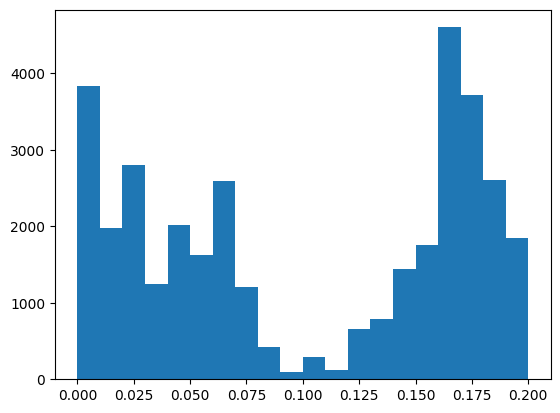

In [15]:
from matplotlib import pyplot as plt
plt.hist(df_saccades.Start_Time,20);

### Split Odd- vs. Even-Day Trials & Stimulus-Average Responses

This step takes the aggregated trial-level arrays and produces
stimulus-wise averages for **odd** and **even recording days** separately.

#### Workflow

| Stage | Action | Detail |
|-------|--------|--------|
| **1. Load aggregated data** | `recording_metadata.csv`, `aggregated_spike_counts.npy`, `aggregated_eye_pos.npy`, `aggregated_pupil.npy` | Shapes: (nTrials × 96 × 20), (nTrials × 20 × 2), (nTrials × 20) |
| **2. Temporal sort** | Sort trials by `recording_date` + `time_of_stimulus` | Guarantees chronological order within a day |
| **3. Session index** | Map each `recording_date` → integer index | Needed to tag even vs odd days |
| **4. Trial-exclusion masks** | *a)* Drop any stimulus that repeats within the **previous two trials** of the same day<br>*b)* Require fixation radius < 2° for the **entire 0–200 ms window** | Reduces adaptation effects and eye-movement artefacts |
| **5. Session-specific outlier filter** | Within each day, discard trials whose **mean firing rate** falls outside the 0.1-th–99.9-th percentile range | Removes electrical artefacts or silent blocks |
| **6. Session baseline shift** | For every session, subtract the channel-wise mean firing rate (averaged over time bins) before averaging | Aligns days with different baselines |
| **7. Odd/Even split & averaging** | For each `stimId`, compute the mean of baseline-shifted trials **separately** for odd-indexed sessions and even-indexed sessions | For each channel, outliers are prevented by clipping rates between 1st and 99th percentiles |
| **8. Eye & pupil means** | Simultaneously average eye-position (20 samples @ 100 Hz) and pupil traces for odd vs even groups | For control analysis |
| **9. Save outputs** | ```
Spike_count_even_sessions.npy   # (nStim × 96 × 20)
Spike_count_odd_sessions.npy
Mean_eye_position_even_sessions.npy   # (nStim × 20 × 2)
Mean_eye_position_odd_sessions.npy
Mean_pupil_size_even_sessions.npy     # (nStim × 20)
Mean_pupil_size_odd_sessions.npy

In [16]:
metadata_csv = "recording_metadata.csv"
spike_file = "aggregated_spike_counts.npy"
eye_file = "aggregated_eye_pos.npy"
pupil_file = "aggregated_pupil.npy"
n_stim_ids = 3200
output_prefix = ""

print("Loading data...")

# 1) Load data
metadata_df = pd.read_csv(metadata_csv)
all_spike_counts = np.load(spike_file)   # shape: (nTrials, 96, 20)
all_eye_pos = np.load(eye_file)          # shape: (nTrials, 20, 2)
all_pupil = np.load(pupil_file)          # shape: (nTrials, 20)

# 2) Sort trials by [recording_date, time_of_stimulus]
if "time_of_stimulus" not in metadata_df.columns:
    raise ValueError("Metadata must have a 'time_of_stimulus' column for sorting.")

metadata_df["sort_key"] = (
    metadata_df["recording_date"].astype(str) + "_" +
    metadata_df["time_of_stimulus"].astype(str)
)
sorted_indices = np.argsort(metadata_df["sort_key"].values)

metadata_df = metadata_df.iloc[sorted_indices].reset_index(drop=True)
all_spike_counts = all_spike_counts[sorted_indices]
all_eye_pos = all_eye_pos[sorted_indices]
all_pupil = all_pupil[sorted_indices]

# 3) Compute day indices (sessions) for each trial
unique_days = np.sort(metadata_df["recording_date"].unique())
day_index_map = {day: i for i, day in enumerate(unique_days)}
day_indices = metadata_df["recording_date"].map(day_index_map).values

# 4) Identify non-repeating stimuli
nTrials = len(metadata_df)
non_repeating_stimuli = np.ones(nTrials, dtype=bool)
stim_ids_series = metadata_df["stimId"].values

for i in range(1, nTrials):
    start_idx = max(0, i - 2)
    if np.any(stim_ids_series[start_idx:i] == stim_ids_series[i]):
        non_repeating_stimuli[i] = False

# 5) Identify in-fixation-window trials (within 2° radius during all 20 samples)
radius = np.sqrt(all_eye_pos[..., 0]**2 + all_eye_pos[..., 1]**2)  # (nTrials, 20)
in_fix_window_trials = np.mean(radius < 2, axis=1) == 1

# 6) Apply validity mask and filter outliers by session
valid_mask = non_repeating_stimuli & in_fix_window_trials
sessions = np.unique(day_indices)

for s in sessions:
    session_indices = np.where(day_indices == s)[0]
    valid_session_indices = session_indices[valid_mask[session_indices]]
    if valid_session_indices.size > 0:
        trial_mean_fr = np.mean(all_spike_counts[valid_session_indices], axis=(1, 2))
        lo = np.percentile(trial_mean_fr, 0.1)
        hi = np.percentile(trial_mean_fr, 99.9)
        condition = (trial_mean_fr > lo) & (trial_mean_fr < hi)
        valid_mask[valid_session_indices] = condition

# 7) Compute per-session mean for baseline shift
session_means = {}
for s in sessions:
    valid_trials = np.where((day_indices == s) & valid_mask)[0]
    if valid_trials.size > 0:
        session_means[s] = np.mean(all_spike_counts[valid_trials], axis=(0, 2))  # (96,)
    else:
        session_means[s] = np.zeros(96)

# 8) Initialize output arrays for spike counts
Spike_count_even = np.full((n_stim_ids, 96, 20), np.nan, dtype=np.float32)
Spike_count_odd  = np.full((n_stim_ids, 96, 20), np.nan, dtype=np.float32)

print("Computing session-based shifted averages per stimulus, excluding bad trials...")

# Loop over each stimulus
for stim_id in range(n_stim_ids):
    stim_indices = np.where((stim_ids_series == stim_id) & valid_mask)[0]
    if stim_indices.size == 0:
        continue

    even_indices = stim_indices[(day_indices[stim_indices] % 2) == 0]
    odd_indices  = stim_indices[(day_indices[stim_indices] % 2) == 1]

    shifted_trials_even = [
        all_spike_counts[idx] - session_means[day_indices[idx]][:, None]
        for idx in even_indices
    ]
    if shifted_trials_even:
        Spike_count_even[stim_id] = np.mean(shifted_trials_even, axis=0)

    shifted_trials_odd = [
        all_spike_counts[idx] - session_means[day_indices[idx]][:, None]
        for idx in odd_indices
    ]
    if shifted_trials_odd:
        Spike_count_odd[stim_id] = np.mean(shifted_trials_odd, axis=0)

# 9) Clip spike counts channel-wise between 1st and 99th percentiles
def clip_spike_count(spike_count):
    rate_channel = spike_count.swapaxes(0, 1).reshape(96, -1)
    low, high = np.percentile(rate_channel, [1, 99], axis=1)
    clipped = np.clip(rate_channel, low[:, None], high[:, None])
    return clipped.reshape(spike_count.swapaxes(0, 1).shape).swapaxes(0, 1)

Spike_count_even = clip_spike_count(Spike_count_even)
Spike_count_odd = clip_spike_count(Spike_count_odd)

# 10) Initialize output arrays for eye and pupil signals
Mean_eye_position_even = np.full((n_stim_ids, 20, 2), np.nan, dtype=np.float32)
Mean_eye_position_odd  = np.full((n_stim_ids, 20, 2), np.nan, dtype=np.float32)
Mean_pupil_size_even   = np.full((n_stim_ids, 20), np.nan, dtype=np.float32)
Mean_pupil_size_odd    = np.full((n_stim_ids, 20), np.nan, dtype=np.float32)

print("Computing mean eye position and pupil size per stimulus for even and odd sessions...")

# Loop over each stimulus ID for eye/pupil averaging
for stim_id in range(n_stim_ids):
    stim_indices = np.where((stim_ids_series == stim_id) & valid_mask)[0]
    if stim_indices.size == 0:
        continue

    even_indices = stim_indices[(day_indices[stim_indices] % 2) == 0]
    odd_indices  = stim_indices[(day_indices[stim_indices] % 2) == 1]

    if even_indices.size > 0:
        Mean_eye_position_even[stim_id] = np.mean(all_eye_pos[even_indices], axis=0)
        Mean_pupil_size_even[stim_id] = np.mean(all_pupil[even_indices], axis=0)
    if odd_indices.size > 0:
        Mean_eye_position_odd[stim_id] = np.mean(all_eye_pos[odd_indices], axis=0)
        Mean_pupil_size_odd[stim_id] = np.mean(all_pupil[odd_indices], axis=0)

# Add splitting of df_saccades
if 'df_saccades' in locals() and not df_saccades.empty:
    df_saccades_even = df_saccades[df_saccades['Trial'].isin(np.where((day_indices % 2) == 0)[0])].copy()
    df_saccades_odd = df_saccades[df_saccades['Trial'].isin(np.where((day_indices % 2) == 1)[0])].copy()

    # Add 'stimId' column to df_saccades_even and df_saccades_odd by merging with metadata_df
    df_saccades_even = pd.merge(df_saccades_even, metadata_df[['trial_index_global', 'stimId']],
                                left_on='Trial', right_on='trial_index_global', how='left').drop(columns='trial_index_global')
    df_saccades_odd = pd.merge(df_saccades_odd, metadata_df[['trial_index_global', 'stimId']],
                               left_on='Trial', right_on='trial_index_global', how='left').drop(columns='trial_index_global')

else:
    print("Warning: df_saccades not found or empty. Cannot create df_saccades_even and df_saccades_odd.")
    df_saccades_even = pd.DataFrame()
    df_saccades_odd = pd.DataFrame()


# 11) Save the results
print("Saving outputs...")
np.save(f"{output_prefix}Spike_count_even_sessions.npy", Spike_count_even)
np.save(f"{output_prefix}Spike_count_odd_sessions.npy", Spike_count_odd)
np.save(f"{output_prefix}Mean_eye_position_even_sessions.npy", Mean_eye_position_even)
np.save(f"{output_prefix}Mean_eye_position_odd_sessions.npy", Mean_eye_position_odd)
np.save(f"{output_prefix}Mean_pupil_size_even_sessions.npy", Mean_pupil_size_even)
np.save(f"{output_prefix}Mean_pupil_size_odd_sessions.npy", Mean_pupil_size_odd)

# Save df_saccades_even and df_saccades_odd as pickle files
if not df_saccades_even.empty:
    df_saccades_even.to_pickle(f"{output_prefix}df_saccades_even.pkl")
    print("Saved df_saccades_even.pkl")
if not df_saccades_odd.empty:
    df_saccades_odd.to_pickle(f"{output_prefix}df_saccades_odd.pkl")
    print("Saved df_saccades_odd.pkl")


print("Done! Session-split shifted arrays and mean signals saved.")

Loading data...
Computing session-based shifted averages per stimulus, excluding bad trials...
Computing mean eye position and pupil size per stimulus for even and odd sessions...
Saving outputs...
Saved df_saccades_even.pkl
Saved df_saccades_odd.pkl
Done! Session-split shifted arrays and mean signals saved.


### Package Final Outputs into a ZIP Archive

This cell creates a compressed archive containing the final, downstream files:

- `aggregated_spike_counts.npy`  
- `aggregated_eye_pos.npy`  
- `aggregated_pupil.npy`  
- `recording_metadata.csv`  
- `Spike_count_even_sessions.npy`  
- `Spike_count_odd_sessions.npy`  
- `Mean_eye_position_even_sessions.npy`  
- `Mean_eye_position_odd_sessions.npy`  
- `Mean_pupil_size_even_sessions.npy`  
- `Mean_pupil_size_odd_sessions.npy`  
- `df_saccades_even.pkl`
- `df_saccades_odd.pkl`


In [49]:
# Output archive name
output_zip = "final_outputs.zip"

# Regex patterns for files to include
include_patterns = [
    r"^aggregated_spike_counts\.npy$",
    r"^aggregated_eye_pos\.npy$",
    r"^aggregated_pupil\.npy$",
    r"^recording_metadata\.csv$",
    r"^Spike_count_even_sessions\.npy$",
    r"^Spike_count_odd_sessions\.npy$",
    r"^Mean_eye_position_even_sessions\.npy$",
    r"^Mean_eye_position_odd_sessions\.npy$",
    r"^Mean_pupil_size_even_sessions\.npy$",
    r"^Mean_pupil_size_odd_sessions\.npy$",
    r"^df_saccades_even\.pkl$",
    r"^df_saccades_odd\.pkl$"
]

# Compile regexes
compiled = [re.compile(p) for p in include_patterns]

with zipfile.ZipFile(output_zip, mode="w", compression=zipfile.ZIP_DEFLATED) as zf:
    for fname in os.listdir("."):
        # Only include files (no directories)
        if not os.path.isfile(fname):
            continue
        # Check if filename matches any include pattern
        if any(rx.match(fname) for rx in compiled):
            print(f"Adding {fname}")
            zf.write(fname, arcname=fname)

print(f"\nCreated archive with final outputs: {output_zip}")


Adding recording_metadata.csv
Adding df_saccades_even.pkl
Adding Spike_count_odd_sessions.npy
Adding Mean_eye_position_even_sessions.npy
Adding Mean_eye_position_odd_sessions.npy
Adding Mean_pupil_size_odd_sessions.npy
Adding aggregated_pupil.npy
Adding aggregated_eye_pos.npy
Adding aggregated_spike_counts.npy
Adding df_saccades_odd.pkl
Adding Spike_count_even_sessions.npy
Adding Mean_pupil_size_even_sessions.npy

Created archive with final outputs: final_outputs.zip
